# 비디오 프레임 추출
## cv2 설치
`pip install opencv-contrib-python`

$\sum |I_1(i,j) - I_2(i+x,j+y) | $로 평가?

$ score =  \left( \sum_{i=x}^{(n-1)-x}  ( f(i+x)-f(i) )^2  \right) $ 최소로

$\frac {\partial score} {\partial x} =  0, \left(f(i+x)-f(i)\right)f'(i+x) = 0 $



In [3]:
import cv2
import numpy
import matplotlib.pyplot as plt

In [4]:
directory = "frame"
# the number of frame
count = 0

def FrameCapture(video):
    global directory, count
    
    # Path to video file 
    videoObject = cv2.VideoCapture(video) 
  
    print(videoObject.isOpened())
    # checks whether frames were extracted 
    success = 1
  
    while success: 
        # videoObject object calls read 
        success, image = videoObject.read() 

        if success != 1: break
        # Saves the frames 
        path = directory + '\\' + "frame%d.png" % count
        print(f"path:{path}")
        cv2.imwrite(path, image) 
  
        count += 1

In [5]:
FrameCapture('data\\video.MOV')

True
path:frame\frame0.png
path:frame\frame1.png
path:frame\frame2.png
path:frame\frame3.png
path:frame\frame4.png
path:frame\frame5.png
path:frame\frame6.png
path:frame\frame7.png
path:frame\frame8.png
path:frame\frame9.png
path:frame\frame10.png
path:frame\frame11.png
path:frame\frame12.png
path:frame\frame13.png
path:frame\frame14.png
path:frame\frame15.png
path:frame\frame16.png
path:frame\frame17.png
path:frame\frame18.png
path:frame\frame19.png
path:frame\frame20.png
path:frame\frame21.png
path:frame\frame22.png
path:frame\frame23.png
path:frame\frame24.png
path:frame\frame25.png
path:frame\frame26.png
path:frame\frame27.png
path:frame\frame28.png
path:frame\frame29.png
path:frame\frame30.png
path:frame\frame31.png
path:frame\frame32.png
path:frame\frame33.png
path:frame\frame34.png
path:frame\frame35.png
path:frame\frame36.png
path:frame\frame37.png
path:frame\frame38.png
path:frame\frame39.png
path:frame\frame40.png
path:frame\frame41.png
path:frame\frame42.png
path:frame\frame

## 이미지 들어간거 찾기

In [253]:
i1 = cv2.imread("frame/frame0.png")
i2 = cv2.imread("frame/frame1.png")
i3 = cv2.imread("frame/frame2.png")
i4 = cv2.imread("frame/frame3.png")
i5 = cv2.imread("frame/frame4.png")
i6 = cv2.imread("frame/frame5.png")
i7 = cv2.imread("frame/frame6.png")

In [34]:
cv2.imshow("im1",i1)
cv2.imshow("im2",i2)
cv2.waitKey(0)

-1

In [43]:
cv2.destroyAllWindows()

In [ ]:
img = i1-i2
cv2.imshow("img",img)
cv2.waitKey(0)

[[40.2093 38.657  36.4461 33.7727 31.9113 32.9537 34.9828 36.9089 38.3241]
 [39.3983 37.66   35.1145 31.958  29.6413 30.9005 33.4599 35.848  37.5515]
 [38.3134 36.326  33.342  29.5109 26.4924 28.127  31.5061 34.5113 36.594 ]
 [36.8164 34.4741 30.8775 26.0493 21.8778 24.2149 28.8695 32.6823 35.2325]
 [34.8933 32.1036 27.7084 21.4036 15.2072 19.0598 25.6113 30.4279 33.5118]
 [33.6671 30.5674 25.6417 18.294  10.0578 15.7653 23.6988 29.1499 32.5751]
 [34.5893 31.7869 27.4061 21.2383 15.454  19.3802 25.9519 30.7614 33.8266]
 [36.1019 33.7249 30.1464 25.5346 21.7442 24.28   29.1915 33.1074 35.6858]
 [37.2857 35.2904 32.3978 28.9192 26.1893 27.9375 31.7376 34.9636 37.1401]]


(0.13309646702673747, 0.8171233352565108)

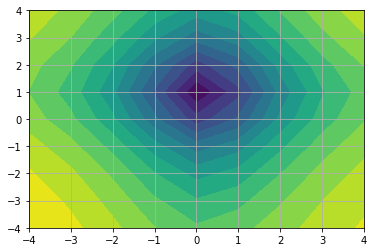

In [302]:
px, py = 0 ,0 

h, w, _ = i1.shape
xl = 4
yl = 4

fw = lambda x:  w if x>=0 else x
fh = lambda x:  h if x>=0 else x

ew = lambda x:  w if x>=0 else x
eh = lambda x:  h if x>=0 else x

xrange = range(-xl+px, xl+1+px)
yrange = range(-yl+py, yl+1+py)

score =  numpy.zeros((xl*2+1,yl*2+1),dtype=int)

for xh in xrange:
    for yh in yrange:
        i_sum = 0
        
        t1 = i1[max(0,yh):h+min(0,yh) , max(0,xh):w+min(0,xh) ]
        t2 = i4[max(0,-yh):h-max(0,yh), max(0,-xh):w-max(0,xh)]
        # print(t1.shape, t2.shape)
        img = t1-t2
        
        score[xh+xl,yh+yl] = sum(sum(sum(numpy.abs(img.astype('int8').astype('int32')))))
        # print(score)


score = score/ (w-xl)/(h-yl)
# score = 1/(score*score)
print(score.round(4))

## 시각화
x,y = numpy.meshgrid(
    numpy.array(xrange),
    numpy.array(yrange)
)

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(x,y,score, cmap="BuPu")
# plt.show()

plt.grid(True)
d = score.reshape((xl*2+1)*(yl*2+1))

mylevels = numpy.linspace(min(d),max(d),15)
ourplot = plt.contourf(x,y,score,levels=mylevels,) #cmap="coolwarm"

sum_xy = lambda x,y : sum([(xh**x)*(yh**y) for xh in xrange for yh in yrange])
view_xy = lambda x,y : sum([(xh**x)*(yh**y)*score[yh+yl, xh+xl] for xh in xrange for yh in yrange])

# x,y = 0,0

diff = [(2,0),(1,1),(0,2),(1,0),(0,1),(0,0)]

A = numpy.array([[sum_xy(x+i,y+j) for x,y in diff] for i,j in diff])
Y = numpy.array([[view_xy(x,y)] for x,y in diff])
invA = numpy.linalg.inv(A)

X = invA@Y
a,b,c,d,e,f =  X.reshape(6)
# -numpy.linalg.inv(numpy.array([[2*a,b],[b,2*c]]))@numpy.array([[d],[e]])
minX, minY = -(b*e-2*c*d)/(b*b-4*a*c), -(b*d-2*a*e)/(b*b-4*a*c)
minX, minY




In [299]:
s = (score).reshape((xl*2+1)*(yl*2+1)).sum()
[
(x*score).reshape((xl*2+1)*(yl*2+1)).sum()/s,
(y*score).reshape((xl*2+1)*(yl*2+1)).sum()/s
]

[0.025734175781299724, 0.6276613915803442]

In [270]:
a = numpy.array(range(9)).reshape((3,3))
a**2

In [304]:
numpy.array([[a*x*x + b*x*y + c*y*y + d*x + e*y + f for x in xrange] for y in yrange]).round(2)

array([[46.35, 40.65, 36.48, 33.84, 32.74, 33.17, 35.14, 38.64, 43.68],
       [42.2 , 36.52, 32.38, 29.77, 28.69, 29.15, 31.14, 34.67, 39.73],
       [38.97, 33.32, 29.21, 26.63, 25.58, 26.07, 28.09, 31.64, 36.73],
       [36.69, 31.07, 26.98, 24.42, 23.4 , 23.92, 25.96, 29.55, 34.66],
       [35.34, 29.75, 25.69, 23.16, 22.16, 22.71, 24.78, 28.39, 33.53],
       [34.93, 29.36, 25.33, 22.83, 21.86, 22.43, 24.53, 28.17, 33.34],
       [35.46, 29.92, 25.91, 23.44, 22.5 , 23.1 , 25.22, 28.89, 34.08],
       [36.93, 31.41, 27.43, 24.99, 24.07, 24.7 , 26.85, 30.54, 35.77],
       [39.33, 33.84, 29.89, 27.47, 26.59, 27.23, 29.42, 33.14, 38.39]])

In [296]:
score

array([[0.02318075, 0.02396068, 0.02512598, 0.02656801, 0.02732141,
        0.02655355, 0.02552366, 0.02464547, 0.02404403],
       [0.02359431, 0.02450135, 0.02590214, 0.02770198, 0.02873196,
        0.02776117, 0.0264112 , 0.02528005, 0.02453252],
       [0.02403977, 0.02510306, 0.02681101, 0.0291219 , 0.03057471,
        0.02924706, 0.02738258, 0.025901  , 0.02496851],
       [0.02463582, 0.02592047, 0.02808147, 0.03124589, 0.03349736,
        0.03144685, 0.02868558, 0.02669077, 0.02549397],
       [0.02554577, 0.02718663, 0.03011562, 0.03492124, 0.03897792,
        0.03515188, 0.03069915, 0.02789795, 0.0263173 ],
       [0.02680806, 0.02898108, 0.03316571, 0.04135344, 0.05047097,
        0.0412903 , 0.03355655, 0.02953694, 0.02743705],
       [0.02778404, 0.03042711, 0.0357807 , 0.04779473, 0.06612921,
        0.04703024, 0.03577054, 0.0307015 , 0.02818275],
       [0.02717972, 0.02948585, 0.03393257, 0.04258403, 0.0522935 ,
        0.04209231, 0.03379268, 0.0295947 , 0.02743055],


(0.014868623858982999, 0.4703768436590926)

In [211]:
[[for xh in range(-xl, xl+1)] for yh in range(-yl, yl+1)]

(0.4703768436590926, 0.014868623858982999)

In [223]:
k= numpy.array(range(3**2)).reshape((3,3))
k

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [228]:
w, h

(1440, 1920)

In [121]:
sum(numpy.abs(img.astype('int8')))

array([[ 108,  -20,  -54],
       [  70,  -16,  -68],
       [  55,  -37,  -93],
       ...,
       [  33,   71, -116],
       [ -46, -115,   23],
       [  22,   -2,   44]], dtype=int8)

In [129]:
(score/ (w-xl)/(h-yl)).round(2)

array([[38.28, 37.21, 35.72, 33.77, 31.94, 32.44, 34.07, 35.54, 36.56],
       [36.39, 35.06, 33.17, 30.72, 28.36, 29.06, 31.2 , 33.16, 34.6 ],
       [33.67, 31.87, 29.34, 25.97, 22.69, 23.74, 26.87, 29.74, 31.88],
       [30.45, 27.97, 24.38, 19.37, 14.14, 16.07, 21.3 , 25.7 , 28.82],
       [28.57, 25.49, 20.89, 14.06,  5.36,  9.55, 17.38, 23.02, 26.78],
       [30.35, 27.78, 24.1 , 19.19, 14.34, 16.63, 21.85, 26.06, 28.99],
       [32.96, 31.17, 28.68, 25.55, 22.68, 24.15, 27.53, 30.43, 32.5 ],
       [35.31, 34.1 , 32.36, 30.19, 28.21, 29.29, 31.76, 33.9 , 35.42],
       [37.  , 36.14, 34.86, 33.19, 31.7 , 32.54, 34.53, 36.22, 37.42]])